<a href="https://colab.research.google.com/github/maximum4645/ComputerVision/blob/main/model_comparison_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, random_split

# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # note: If using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 13.0 MB/s eta 0:00:00
mlxtend version: 0.23.1
0.23.1


# Dataset Downloading Functions

In [61]:
def download_dataset(dataset_name, transform, subset_size, val_size, batch_size):

    if dataset_name == 'CIFAR10':
        train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        classes = train_set.classes

    elif dataset_name == 'Food101':
        train_set = torchvision.datasets.Food101(root='./data', train=True, download=True, transform=transform)
        test_set = torchvision.datasets.Food101(root='./data', train=False, download=True, transform=transform)
        classes = train_set.classes

    elif dataset_name == 'SVHN':
        train_set = torchvision.datasets.SVHN(root='./data', train=True, download=True, transform=transform)
        test_set = torchvision.datasets.SVHN(root='./data', train=False, download=True, transform=transform)
        classes = [str(i) for i in range(10)] # this dataset doesn't have a .classes attribute

    else:
        raise ValueError(f"Dataset {dataset_name} is not supported.")

    if subset_size:
        indices = torch.randperm(len(train_set))[:subset_size]
        train_subset = Subset(train_set, indices)
        train_size = int((1 - val_size) * subset_size)
        val_size = subset_size - train_size
        train_set, val_set = random_split(train_subset, [train_size, val_size])
    else:
        train_size = int((1 - val_size) * len(train_set))
        val_size = len(train_set) - train_size
        train_set, val_set = random_split(train_set, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, classes

# Models

In [ ]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [ ]:
pretrained_weights_0 = models.AlexNet_Weights.IMAGENET1K_V1
pretrained_weights_1 = models.DenseNet161_Weights.IMAGENET1K_V1
pretrained_weights_2 = models.EfficientNet_B2_Weights.IMAGENET1K_V1
pretrained_weights_3 = models.VGG11_BN_Weights.IMAGENET1K_V1

pretrained_models = {
    0 : models.alexnet(weights=pretrained_weights_0),
    1 : models.densenet161(weights=pretrained_weights_1),
    2 : models.efficientnet_b2(weights=pretrained_weights_2),
    3 : models.vgg11_bn(weights=pretrained_weights_3)
}

preprocesses = {
    0: pretrained_weights_0.transforms(),
    1: pretrained_weights_1.transforms(),
    2: pretrained_weights_2.transforms(),
    3: pretrained_weights_3.transforms()
}

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 92.5MB/s]
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:08<00:00, 14.0MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 124MB/s]
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:07<00:00, 73.9MB/s]


### Modify the output layer of model0

In [ ]:
pretrained_models[0]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
pretrained_models[0].classifier[6] = nn.Linear(in_features=4096, out_features=10)

### Modify the output layer of model1

In [ ]:
pretrained_models[1]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
pretrained_models[1].classifier = nn.Linear(pretrained_models[1].classifier.in_features, 10)

In [ ]:
pretrained_models[1].classifier = nn.Linear(in_features=2208, out_features=10)

### Modify the output layer of model2

In [ ]:
pretrained_models[2]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
pretrained_models[2].classifier = nn.Linear(in_features=1408, out_features=10)

### Modify the output layer of model3

In [ ]:
pretrained_models[3]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
pretrained_models[3].classifier[6] = nn.Linear(in_features=4096, out_features=10)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pretrained_models[0].to(device)
pretrained_models[1].to(device)
pretrained_models[2].to(device)
pretrained_models[3].to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### torchsummary and freeze_layers function

In [ ]:
pip install torch-summary

In [ ]:
from torchsummary import summary

In [ ]:
def freeze_layers(model, layers_to_freeze):
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_freeze):
            param.requires_grad = False
            print(name + ' freezed')

### Freeze some layers of model0

In [ ]:
summary(pretrained_models[0], input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       23,296
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       307,392
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       663,936
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       884,992
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      37,752,832
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Linear: 2-18                    

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       23,296
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       307,392
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       663,936
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       884,992
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      37,752,832
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Linear: 2-18                    

In [ ]:
# Trainable layers
for name, param in pretrained_models[0].named_parameters():
    if param.requires_grad:
        print(name)

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier.6.weight
classifier.6.bias


In [ ]:
layers_to_freeze_0 = ["features.0.", "features.3.", "features.6.",
                      "features.8.", "features.10."]

freeze_layers(pretrained_models[0], layers_to_freeze_0)

# Trainable layers
for name, param in pretrained_models[0].named_parameters():
    if param.requires_grad:
        print(name)

features.0.weight freezed
features.0.bias freezed
features.3.weight freezed
features.3.bias freezed
features.6.weight freezed
features.6.bias freezed
features.8.weight freezed
features.8.bias freezed
features.10.weight freezed
features.10.bias freezed
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier.6.weight
classifier.6.bias


### Freeze some layers of model1

In [ ]:
summary(pretrained_models[1], input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       14,112
|    └─BatchNorm2d: 2-2                  192
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             101,952
|    |    └─_DenseLayer: 3-2             111,264
|    |    └─_DenseLayer: 3-3             120,576
|    |    └─_DenseLayer: 3-4             129,888
|    |    └─_DenseLayer: 3-5             139,200
|    |    └─_DenseLayer: 3-6             148,512
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             768
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  73,728
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            120,576
|    |    └─_DenseLayer: 3-12            129,888
|    |    └─_DenseLay

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       14,112
|    └─BatchNorm2d: 2-2                  192
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             101,952
|    |    └─_DenseLayer: 3-2             111,264
|    |    └─_DenseLayer: 3-3             120,576
|    |    └─_DenseLayer: 3-4             129,888
|    |    └─_DenseLayer: 3-5             139,200
|    |    └─_DenseLayer: 3-6             148,512
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             768
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  73,728
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            120,576
|    |    └─_DenseLayer: 3-12            129,888
|    |    └─_DenseLay

In [ ]:
# Trainable layers
for name, param in pretrained_models[1].named_parameters():
    if param.requires_grad:
        print(name)

features.conv0.weight
features.norm0.weight
features.norm0.bias
features.denseblock1.denselayer1.norm1.weight
features.denseblock1.denselayer1.norm1.bias
features.denseblock1.denselayer1.conv1.weight
features.denseblock1.denselayer1.norm2.weight
features.denseblock1.denselayer1.norm2.bias
features.denseblock1.denselayer1.conv2.weight
features.denseblock1.denselayer2.norm1.weight
features.denseblock1.denselayer2.norm1.bias
features.denseblock1.denselayer2.conv1.weight
features.denseblock1.denselayer2.norm2.weight
features.denseblock1.denselayer2.norm2.bias
features.denseblock1.denselayer2.conv2.weight
features.denseblock1.denselayer3.norm1.weight
features.denseblock1.denselayer3.norm1.bias
features.denseblock1.denselayer3.conv1.weight
features.denseblock1.denselayer3.norm2.weight
features.denseblock1.denselayer3.norm2.bias
features.denseblock1.denselayer3.conv2.weight
features.denseblock1.denselayer4.norm1.weight
features.denseblock1.denselayer4.norm1.bias
features.denseblock1.denselaye

In [ ]:
layers_to_freeze_1 = ["features.conv0", "features.norm0", "features.relu0", "features.pool0",
    "features.denseblock1", "features.transition1",
    "features.denseblock2", "features.transition2",
    "features.denseblock3", "features.transition3"]

freeze_layers(pretrained_models[1], layers_to_freeze_1)

# Trainable layers
for name, param in pretrained_models[1].named_parameters():
    if param.requires_grad:
        print(name)

features.conv0.weight freezed
features.norm0.weight freezed
features.norm0.bias freezed
features.denseblock1.denselayer1.norm1.weight freezed
features.denseblock1.denselayer1.norm1.bias freezed
features.denseblock1.denselayer1.conv1.weight freezed
features.denseblock1.denselayer1.norm2.weight freezed
features.denseblock1.denselayer1.norm2.bias freezed
features.denseblock1.denselayer1.conv2.weight freezed
features.denseblock1.denselayer2.norm1.weight freezed
features.denseblock1.denselayer2.norm1.bias freezed
features.denseblock1.denselayer2.conv1.weight freezed
features.denseblock1.denselayer2.norm2.weight freezed
features.denseblock1.denselayer2.norm2.bias freezed
features.denseblock1.denselayer2.conv2.weight freezed
features.denseblock1.denselayer3.norm1.weight freezed
features.denseblock1.denselayer3.norm1.bias freezed
features.denseblock1.denselayer3.conv1.weight freezed
features.denseblock1.denselayer3.norm2.weight freezed
features.denseblock1.denselayer3.norm2.bias freezed
featur

### Freeze some layers of model2

In [ ]:
summary(pretrained_models[2], input_size=(3, 224, 224))

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       864
|    |    └─BatchNorm2d: 3-2                  64
|    |    └─SiLU: 3-3                         --
|    └─Sequential: 2-2                        --
|    |    └─MBConv: 3-4                       1,448
|    |    └─MBConv: 3-5                       612
|    └─Sequential: 2-3                        --
|    |    └─MBConv: 3-6                       6,004
|    |    └─MBConv: 3-7                       10,710
|    |    └─MBConv: 3-8                       10,710
|    └─Sequential: 2-4                        --
|    |    └─MBConv: 3-9                       16,518
|    |    └─MBConv: 3-10                      43,308
|    |    └─MBConv: 3-11                      43,308
|    └─Sequential: 2-5                        --
|    |    └─MBConv: 3-12                      50,300
|    |    └─MBConv: 3-13        

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       864
|    |    └─BatchNorm2d: 3-2                  64
|    |    └─SiLU: 3-3                         --
|    └─Sequential: 2-2                        --
|    |    └─MBConv: 3-4                       1,448
|    |    └─MBConv: 3-5                       612
|    └─Sequential: 2-3                        --
|    |    └─MBConv: 3-6                       6,004
|    |    └─MBConv: 3-7                       10,710
|    |    └─MBConv: 3-8                       10,710
|    └─Sequential: 2-4                        --
|    |    └─MBConv: 3-9                       16,518
|    |    └─MBConv: 3-10                      43,308
|    |    └─MBConv: 3-11                      43,308
|    └─Sequential: 2-5                        --
|    |    └─MBConv: 3-12                      50,300
|    |    └─MBConv: 3-13        

In [ ]:
# Trainable layers
for name, param in pretrained_models[2].named_parameters():
    if param.requires_grad:
        print(name)

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.0.block.0.0.weight
features.1.0.block.0.1.weight
features.1.0.block.0.1.bias
features.1.0.block.1.fc1.weight
features.1.0.block.1.fc1.bias
features.1.0.block.1.fc2.weight
features.1.0.block.1.fc2.bias
features.1.0.block.2.0.weight
features.1.0.block.2.1.weight
features.1.0.block.2.1.bias
features.1.1.block.0.0.weight
features.1.1.block.0.1.weight
features.1.1.block.0.1.bias
features.1.1.block.1.fc1.weight
features.1.1.block.1.fc1.bias
features.1.1.block.1.fc2.weight
features.1.1.block.1.fc2.bias
features.1.1.block.2.0.weight
features.1.1.block.2.1.weight
features.1.1.block.2.1.bias
features.2.0.block.0.0.weight
features.2.0.block.0.1.weight
features.2.0.block.0.1.bias
features.2.0.block.1.0.weight
features.2.0.block.1.1.weight
features.2.0.block.1.1.bias
features.2.0.block.2.fc1.weight
features.2.0.block.2.fc1.bias
features.2.0.block.2.fc2.weight
features.2.0.block.2.fc2.bias
features.2.0.block.3.0.weight
features.2.0

In [ ]:
layers_to_freeze_2 = ["features.0.", "features.1.", "features.2.",
                      "features.3.", "features.4.", "features.5."]

freeze_layers(pretrained_models[2], layers_to_freeze_2)

# Trainable layers
for name, param in pretrained_models[2].named_parameters():
    if param.requires_grad:
        print(name)

features.0.0.weight freezed
features.0.1.weight freezed
features.0.1.bias freezed
features.1.0.block.0.0.weight freezed
features.1.0.block.0.1.weight freezed
features.1.0.block.0.1.bias freezed
features.1.0.block.1.fc1.weight freezed
features.1.0.block.1.fc1.bias freezed
features.1.0.block.1.fc2.weight freezed
features.1.0.block.1.fc2.bias freezed
features.1.0.block.2.0.weight freezed
features.1.0.block.2.1.weight freezed
features.1.0.block.2.1.bias freezed
features.1.1.block.0.0.weight freezed
features.1.1.block.0.1.weight freezed
features.1.1.block.0.1.bias freezed
features.1.1.block.1.fc1.weight freezed
features.1.1.block.1.fc1.bias freezed
features.1.1.block.1.fc2.weight freezed
features.1.1.block.1.fc2.bias freezed
features.1.1.block.2.0.weight freezed
features.1.1.block.2.1.weight freezed
features.1.1.block.2.1.bias freezed
features.2.0.block.0.0.weight freezed
features.2.0.block.0.1.weight freezed
features.2.0.block.0.1.bias freezed
features.2.0.block.1.0.weight freezed
features

### Freeze some layers of model3

In [ ]:
summary(pretrained_models[3], input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Conv2d: 2-5                       73,856
|    └─BatchNorm2d: 2-6                  256
|    └─ReLU: 2-7                         --
|    └─MaxPool2d: 2-8                    --
|    └─Conv2d: 2-9                       295,168
|    └─BatchNorm2d: 2-10                 512
|    └─ReLU: 2-11                        --
|    └─Conv2d: 2-12                      590,080
|    └─BatchNorm2d: 2-13                 512
|    └─ReLU: 2-14                        --
|    └─MaxPool2d: 2-15                   --
|    └─Conv2d: 2-16                      1,180,160
|    └─BatchNorm2d: 2-17                 1,024
|    └─ReLU: 2-18                        --
|    └─Conv2d: 2-19                      2,359,808
|    └─BatchNorm2d: 2-20         

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Conv2d: 2-5                       73,856
|    └─BatchNorm2d: 2-6                  256
|    └─ReLU: 2-7                         --
|    └─MaxPool2d: 2-8                    --
|    └─Conv2d: 2-9                       295,168
|    └─BatchNorm2d: 2-10                 512
|    └─ReLU: 2-11                        --
|    └─Conv2d: 2-12                      590,080
|    └─BatchNorm2d: 2-13                 512
|    └─ReLU: 2-14                        --
|    └─MaxPool2d: 2-15                   --
|    └─Conv2d: 2-16                      1,180,160
|    └─BatchNorm2d: 2-17                 1,024
|    └─ReLU: 2-18                        --
|    └─Conv2d: 2-19                      2,359,808
|    └─BatchNorm2d: 2-20         

In [ ]:
# Trainable layers
for name, param in pretrained_models[3].named_parameters():
    if param.requires_grad:
        print(name)

features.0.weight
features.0.bias
features.1.weight
features.1.bias
features.4.weight
features.4.bias
features.5.weight
features.5.bias
features.8.weight
features.8.bias
features.9.weight
features.9.bias
features.11.weight
features.11.bias
features.12.weight
features.12.bias
features.15.weight
features.15.bias
features.16.weight
features.16.bias
features.18.weight
features.18.bias
features.19.weight
features.19.bias
features.22.weight
features.22.bias
features.23.weight
features.23.bias
features.25.weight
features.25.bias
features.26.weight
features.26.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [ ]:
layers_to_freeze_3 = ["features.0.", "features.1.", "features.4.",
                      "features.5.", "features.8.", "features.9.",
                      "features.11.", "features.12.", "features.15.",
                      "features.16."]
freeze_layers(pretrained_models[3], layers_to_freeze_3)

# Trainable layers
for name, param in pretrained_models[3].named_parameters():
    if param.requires_grad:
        print(name)

features.0.weight freezed
features.0.bias freezed
features.1.weight freezed
features.1.bias freezed
features.4.weight freezed
features.4.bias freezed
features.5.weight freezed
features.5.bias freezed
features.8.weight freezed
features.8.bias freezed
features.9.weight freezed
features.9.bias freezed
features.11.weight freezed
features.11.bias freezed
features.12.weight freezed
features.12.bias freezed
features.15.weight freezed
features.15.bias freezed
features.16.weight freezed
features.16.bias freezed
features.18.weight
features.18.bias
features.19.weight
features.19.bias
features.22.weight
features.22.bias
features.23.weight
features.23.bias
features.25.weight
features.25.bias
features.26.weight
features.26.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


# Dataset 1 : CIFAR10

## Evaluation Before Training

In [62]:
def evaluate_model(model, test_loader):
    model.eval() # Set model to evaluation mode
    model.to(device)
    num_correct = 0
    num_total = 0
    predictions = []
    with torch.no_grad(): # Disable gradient computation
        for batch_data in test_loader:
            images, labels = batch_data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, batch_predictions = torch.max(outputs.data, 1)

            num_total += labels.size(0)
            num_correct += (batch_predictions == labels).sum().item()
            predictions.append(batch_predictions)

    predictions = torch.cat(predictions) # convert a list of tensors to a tensor
    accuracy = 100 * num_correct / num_total
    print("Total :", num_total)
    print("Correct :", num_correct)
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    return predictions

In [ ]:
subset_size = 2000
val_size = 0.2  # 20% for validation

In [ ]:
initial_predictions = {}
confusion_matrix_tensors = {}
classes_dict = {}
for key in pretrained_models:
    train_loader, val_loader, test_loader, classes_dict[key] = download_dataset(
                                                    dataset_name = 'CIFAR10',
                                                    transform = preprocesses[key],
                                                    subset_size = subset_size,
                                                    val_size = val_size,
                                                    batch_size = 32)
    print('Model :', pretrained_models[key].__class__.__name__)
    initial_predictions[key] = evaluate_model(pretrained_models[key], test_loader)
    print()

    # Setup confusion matrix instance and compare predictions to targets
    confusion_matrix = ConfusionMatrix(num_classes=len(classes_dict[key]), task='multiclass')
    confusion_matrix = confusion_matrix.to(device)
    initial_predictions[key] = initial_predictions[key].to(device)
    target_tensor = torch.tensor(test_loader.dataset.targets).to(device)
    confusion_matrix_tensors[key] = confusion_matrix(preds=initial_predictions[key], target=target_tensor)

Files already downloaded and verified
Files already downloaded and verified
Model : AlexNet
Total : 10000
Correct : 839
Accuracy of the model on the test images: 8.39%

Files already downloaded and verified
Files already downloaded and verified
Model : DenseNet
Total : 10000
Correct : 839
Accuracy of the model on the test images: 8.39%

Files already downloaded and verified
Files already downloaded and verified
Model : EfficientNet
Total : 10000
Correct : 1112
Accuracy of the model on the test images: 11.12%

Files already downloaded and verified
Files already downloaded and verified
Model : VGG
Total : 10000
Correct : 1131
Accuracy of the model on the test images: 11.31%



## Confusion Matrix Before Training

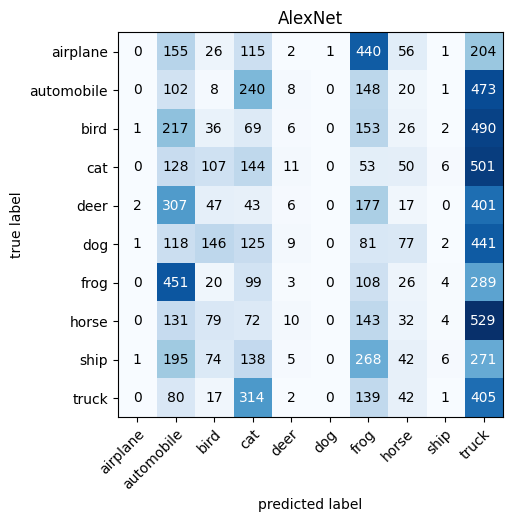

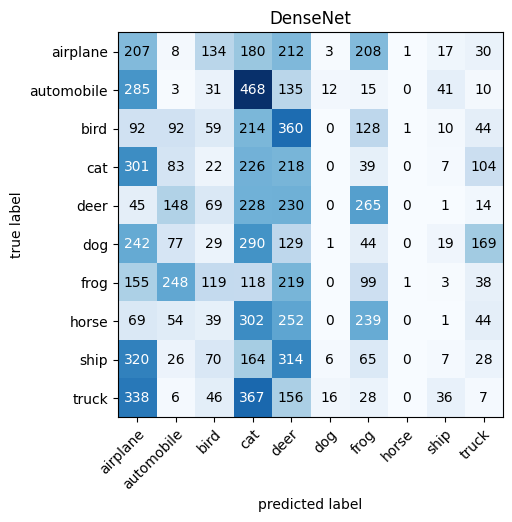

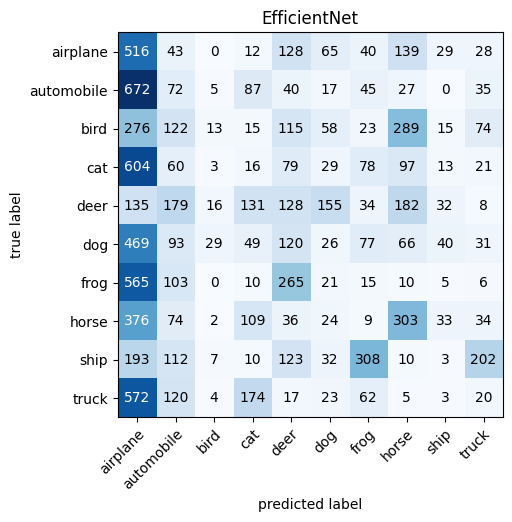

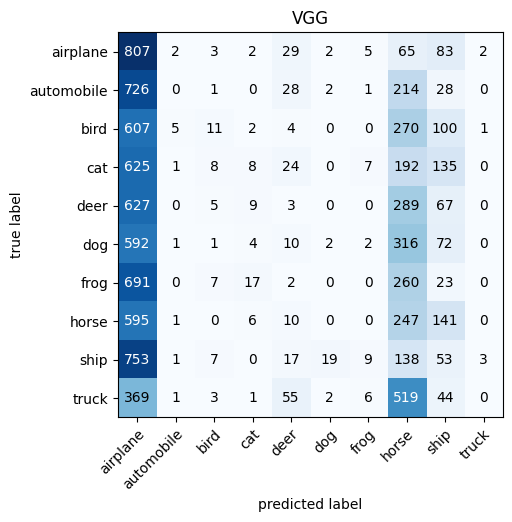

In [68]:
for key in pretrained_models:
    fig, ax = plot_confusion_matrix(
                                conf_mat=confusion_matrix_tensors[key].cpu().numpy(),
                                class_names=classes_dict[key],
                                figsize=(5, 5));
    plt.title(str(pretrained_models[key].__class__.__name__))

## Training

In [67]:
def train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):

        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, batch_data in enumerate(train_loader, 0):
            inputs, labels = batch_data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimize the parameters

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():  # Disable gradient computation
            for val_batch_data in val_loader:
                val_inputs, val_labels = val_batch_data
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                # Calculate validation accuracy
                _, predicted = torch.max(val_outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (predicted == val_labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}, Val Acc: {val_accuracies[-1]:.2f}')

    print('Finished Training')
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [69]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizers = {}
for key in pretrained_models:
    optimizers[key] = optim.Adam(filter( lambda p: p.requires_grad, pretrained_models[key].parameters() ), lr=0.0001)

In [70]:
num_epochs = 15
finetuned_models_cifar10 = {}

print('Model 0')
finetuned_models_cifar10[0], train_loss0, val_loss0, train_acc0, val_acc0 = train_model(pretrained_models[0], criterion, optimizers[0], num_epochs, train_loader, val_loader)

print('\n' + 'Model 1')
finetuned_models_cifar10[1], train_loss1, val_loss1, train_acc1, val_acc1 = train_model(pretrained_models[1], criterion, optimizers[1], num_epochs, train_loader, val_loader)

print('\n' + 'Model 2')
finetuned_models_cifar10[2], train_loss2, val_loss2, train_acc2, val_acc2 = train_model(pretrained_models[2], criterion, optimizers[2], num_epochs, train_loader, val_loader)

print('\n' + 'Model 3')
finetuned_models_cifar10[3], train_loss3, val_loss3, train_acc3, val_acc3 = train_model(pretrained_models[3], criterion, optimizers[3], num_epochs, train_loader, val_loader)

Model 0
Epoch [1/15], Train Loss: 1.2945, Val Loss: 0.9478, Train Acc: 55.75, Val Acc: 66.75
Epoch [2/15], Train Loss: 0.5970, Val Loss: 0.8955, Train Acc: 80.06, Val Acc: 67.00
Epoch [3/15], Train Loss: 0.3863, Val Loss: 0.8466, Train Acc: 88.25, Val Acc: 70.25
Epoch [4/15], Train Loss: 0.2432, Val Loss: 0.7404, Train Acc: 91.69, Val Acc: 76.00
Epoch [5/15], Train Loss: 0.1320, Val Loss: 0.8211, Train Acc: 97.00, Val Acc: 73.50
Epoch [6/15], Train Loss: 0.0997, Val Loss: 0.8623, Train Acc: 97.12, Val Acc: 72.50
Epoch [7/15], Train Loss: 0.0701, Val Loss: 0.7852, Train Acc: 98.00, Val Acc: 76.75
Epoch [8/15], Train Loss: 0.0469, Val Loss: 0.8413, Train Acc: 99.25, Val Acc: 74.50
Epoch [9/15], Train Loss: 0.0302, Val Loss: 0.8750, Train Acc: 99.38, Val Acc: 75.75
Epoch [10/15], Train Loss: 0.0285, Val Loss: 0.9483, Train Acc: 99.44, Val Acc: 72.75
Epoch [11/15], Train Loss: 0.0250, Val Loss: 0.9520, Train Acc: 99.50, Val Acc: 74.50
Epoch [12/15], Train Loss: 0.0207, Val Loss: 1.0258, Tr

## Evaluation After Training

In [71]:
final_predictions = {}
confusion_matrix_tensors = {}

for key in finetuned_models_cifar10:
    print('Model :', finetuned_models_cifar10[key].__class__.__name__)
    final_predictions[key] = evaluate_model(finetuned_models_cifar10[key], test_loader)
    print()

    # Setup confusion matrix instance and compare predictions to targets
    confusion_matrix = ConfusionMatrix(num_classes=len(classes_dict[key]), task='multiclass')
    confusion_matrix = confusion_matrix.to(device)
    final_predictions[key] = final_predictions[key].to(device)
    target_tensor = torch.tensor(test_loader.dataset.targets).to(device)
    confusion_matrix_tensors[key] = confusion_matrix(preds=final_predictions[key], target=target_tensor)

Model : AlexNet
Total : 10000
Correct : 7476
Accuracy of the model on the test images: 74.76%

Model : DenseNet
Total : 10000
Correct : 8161
Accuracy of the model on the test images: 81.61%

Model : EfficientNet
Total : 10000
Correct : 8587
Accuracy of the model on the test images: 85.87%

Model : VGG
Total : 10000
Correct : 7889
Accuracy of the model on the test images: 78.89%



## Confusion Matrix After Training

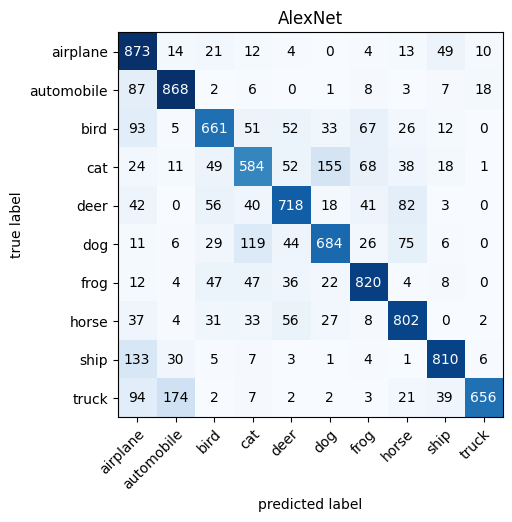

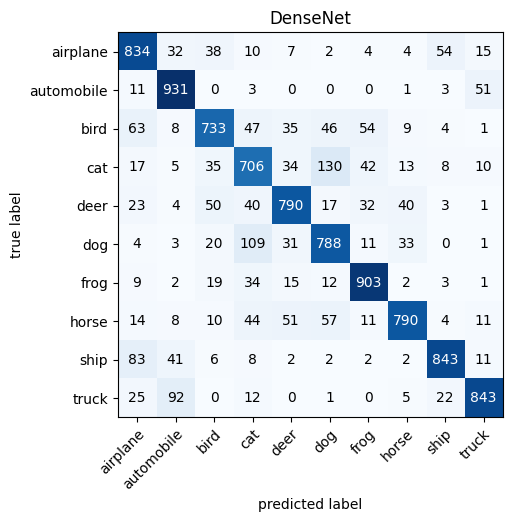

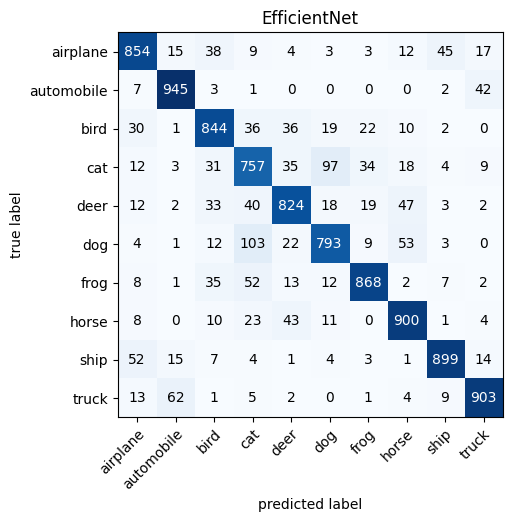

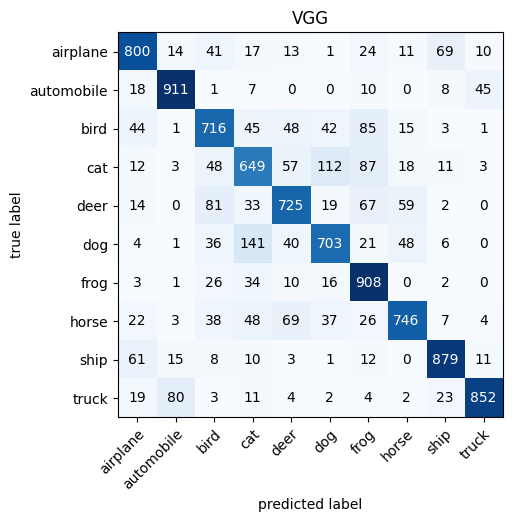

In [72]:
for key in finetuned_models_cifar10:
    fig, ax = plot_confusion_matrix(
                                conf_mat=confusion_matrix_tensors[key].cpu().numpy(),
                                class_names=classes_dict[key],
                                figsize=(5, 5));
    plt.title(str(finetuned_models_cifar10[key].__class__.__name__))

## Loss Curves

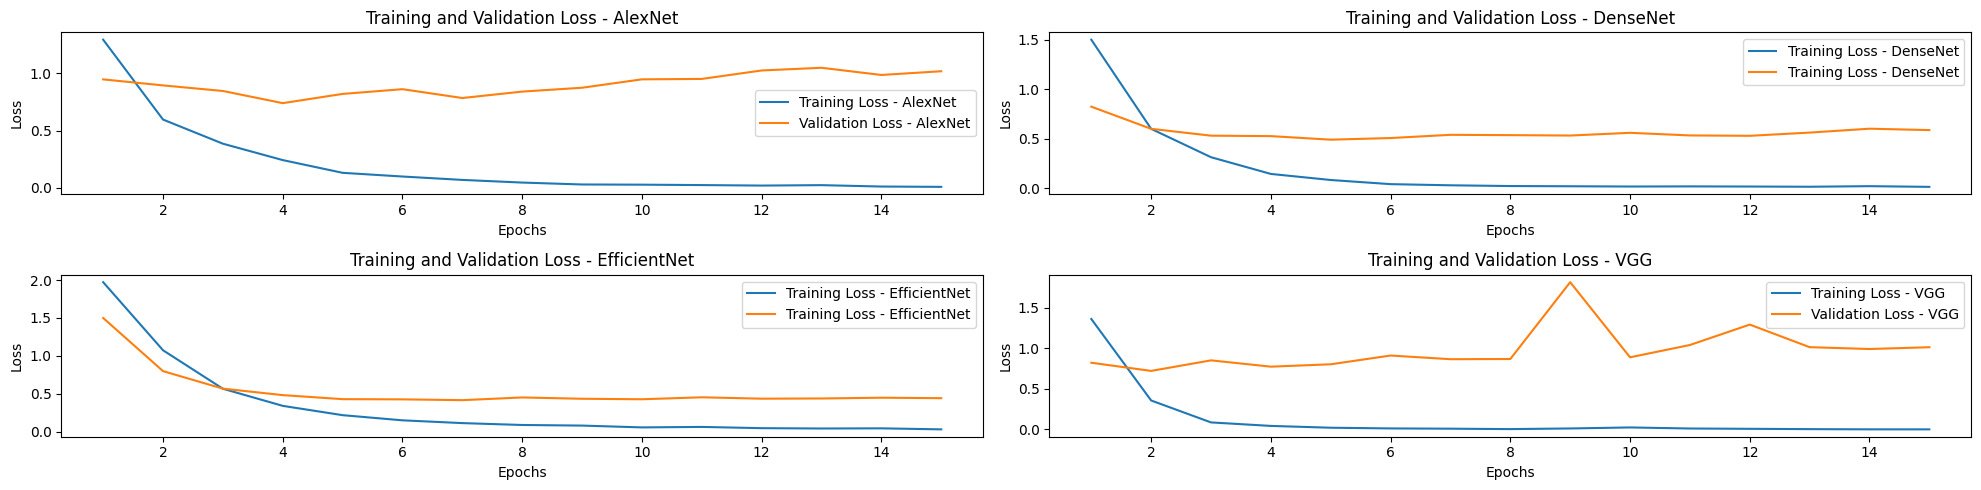

In [73]:
num_epochs = len(train_loss0)  # assuming both have the same number of epochs

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 5))

# Plot training and validation curves for AlexNet
axes[0, 0].plot(range(1, num_epochs + 1), train_loss0, label='Training Loss - ' + str(pretrained_models[0].__class__.__name__))
axes[0, 0].plot(range(1, num_epochs + 1), val_loss0, label='Validation Loss - ' + str(pretrained_models[0].__class__.__name__))
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss - ' + str(pretrained_models[0].__class__.__name__))
axes[0, 0].legend()

# Plot training and validation curves for DenseNet161
axes[0, 1].plot(range(1, num_epochs + 1), train_loss1, label='Training Loss - ' + str(pretrained_models[1].__class__.__name__))
axes[0, 1].plot(range(1, num_epochs + 1), val_loss1, label='Training Loss - ' + str(pretrained_models[1].__class__.__name__))
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Training and Validation Loss - ' + str(pretrained_models[1].__class__.__name__))
axes[0, 1].legend()

# Plot training and validation curves for EfficientNet_B2
axes[1, 0].plot(range(1, num_epochs + 1), train_loss2, label='Training Loss - ' + str(pretrained_models[2].__class__.__name__))
axes[1, 0].plot(range(1, num_epochs + 1), val_loss2, label='Training Loss - ' + str(pretrained_models[2].__class__.__name__))
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training and Validation Loss - ' + str(pretrained_models[2].__class__.__name__))
axes[1, 0].legend()

# Plot training and validation curves for VGG11_BN
axes[1, 1].plot(range(1, num_epochs + 1), train_loss3, label='Training Loss - ' + str(pretrained_models[3].__class__.__name__))
axes[1, 1].plot(range(1, num_epochs + 1), val_loss3, label='Validation Loss - ' + str(pretrained_models[3].__class__.__name__))
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Training and Validation Loss - ' + str(pretrained_models[3].__class__.__name__))
axes[1, 1].legend()

plt.tight_layout()
plt.show()

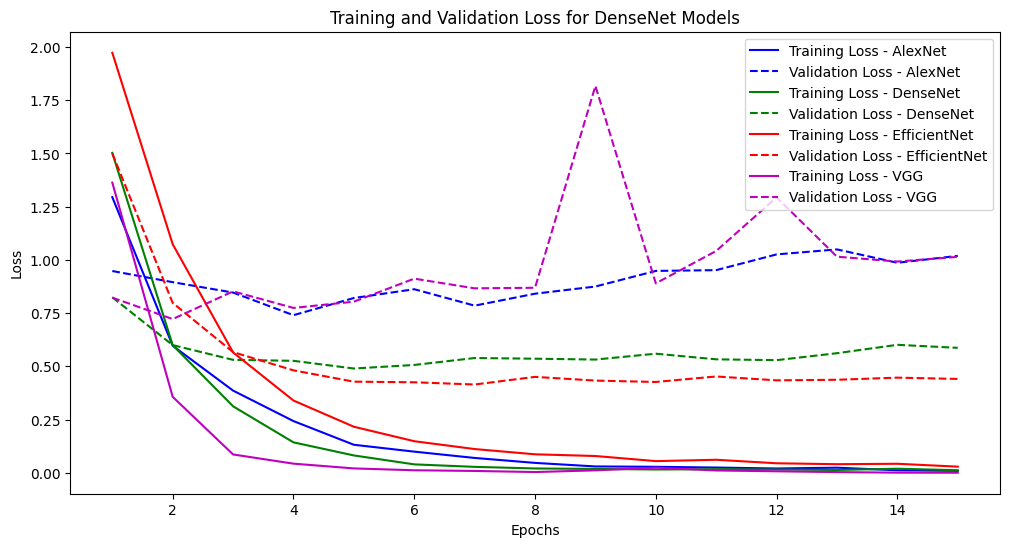

In [74]:
import matplotlib.pyplot as plt

# Number of epochs
num_epochs = len(train_loss0)  # assuming all have the same number of epochs

# Create a single plot
plt.figure(figsize=(12, 6))

# Plot training and validation curves for AlexNet
plt.plot(range(1, num_epochs + 1), train_loss0, label='Training Loss - ' + str(pretrained_models[0].__class__.__name__), color='b')
plt.plot(range(1, num_epochs + 1), val_loss0, label='Validation Loss - ' + str(pretrained_models[0].__class__.__name__), linestyle='--', color='b')

# Plot training and validation curves for DenseNet161
plt.plot(range(1, num_epochs + 1), train_loss1, label='Training Loss - ' + str(pretrained_models[1].__class__.__name__), color='g')
plt.plot(range(1, num_epochs + 1), val_loss1, label='Validation Loss - ' + str(pretrained_models[1].__class__.__name__), linestyle='--', color='g')

# Plot training and validation curves for EfficientNet_B2
plt.plot(range(1, num_epochs + 1), train_loss2, label='Training Loss - ' + str(pretrained_models[2].__class__.__name__), color='r')
plt.plot(range(1, num_epochs + 1), val_loss2, label='Validation Loss - ' + str(pretrained_models[2].__class__.__name__), linestyle='--', color='r')

# Plot training and validation curves for VGG11_BN
plt.plot(range(1, num_epochs + 1), train_loss3, label='Training Loss - ' + str(pretrained_models[3].__class__.__name__), color='m')
plt.plot(range(1, num_epochs + 1), val_loss3, label='Validation Loss - ' + str(pretrained_models[3].__class__.__name__), linestyle='--', color='m')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for DenseNet Models')
plt.legend()

# Show the plot
plt.show()

## Accuracy Curves

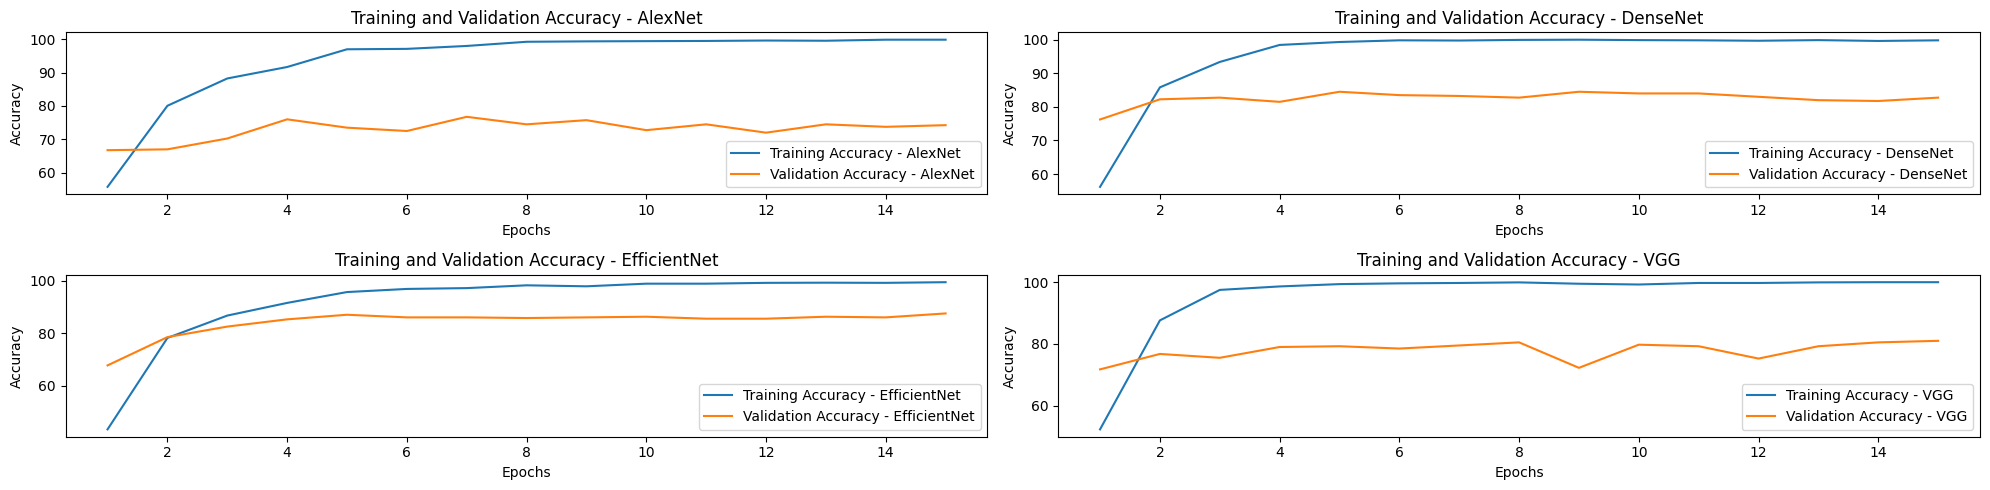

In [75]:
num_epochs = len(train_acc0)  # assuming both have the same number of epochs

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 5))

# Plot training and validation curves for AlexNet
axes[0, 0].plot(range(1, num_epochs + 1), train_acc0, label='Training Accuracy - ' + str(pretrained_models[0].__class__.__name__))
axes[0, 0].plot(range(1, num_epochs + 1), val_acc0, label='Validation Accuracy - ' + str(pretrained_models[0].__class__.__name__))
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Training and Validation Accuracy - ' + str(pretrained_models[0].__class__.__name__))
axes[0, 0].legend()

# Plot training and validation curves for DenseNet161
axes[0, 1].plot(range(1, num_epochs + 1), train_acc1, label='Training Accuracy - ' + str(pretrained_models[1].__class__.__name__))
axes[0, 1].plot(range(1, num_epochs + 1), val_acc1, label='Validation Accuracy - ' + str(pretrained_models[1].__class__.__name__))
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy - ' + str(pretrained_models[1].__class__.__name__))
axes[0, 1].legend()

# Plot training and validation curves for EfficientNet_B2
axes[1, 0].plot(range(1, num_epochs + 1), train_acc2, label='Training Accuracy - ' + str(pretrained_models[2].__class__.__name__))
axes[1, 0].plot(range(1, num_epochs + 1), val_acc2, label='Validation Accuracy - ' + str(pretrained_models[2].__class__.__name__))
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Training and Validation Accuracy - ' + str(pretrained_models[2].__class__.__name__))
axes[1, 0].legend()

# Plot training and validation curves for VGG11_BN
axes[1, 1].plot(range(1, num_epochs + 1), train_acc3, label='Training Accuracy - ' + str(pretrained_models[3].__class__.__name__))
axes[1, 1].plot(range(1, num_epochs + 1), val_acc3, label='Validation Accuracy - ' + str(pretrained_models[3].__class__.__name__))
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Training and Validation Accuracy - ' + str(pretrained_models[3].__class__.__name__))
axes[1, 1].legend()

plt.tight_layout()
plt.show()

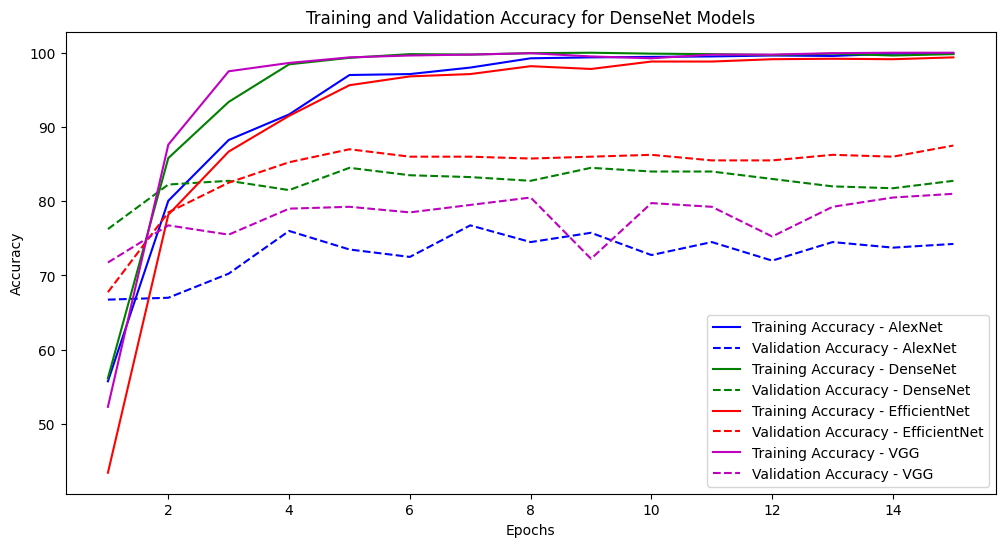

In [76]:
import matplotlib.pyplot as plt

# Number of epochs
num_epochs = len(train_acc0)  # assuming all have the same number of epochs

# Create a single plot
plt.figure(figsize=(12, 6))

# Plot training and validation curves for AlexNet
plt.plot(range(1, num_epochs + 1), train_acc0, label='Training Accuracy - ' + str(pretrained_models[0].__class__.__name__), color='b')
plt.plot(range(1, num_epochs + 1), val_acc0, label='Validation Accuracy - ' + str(pretrained_models[0].__class__.__name__), linestyle='--', color='b')

# Plot training and validation curves for DenseNet161
plt.plot(range(1, num_epochs + 1), train_acc1, label='Training Accuracy - ' + str(pretrained_models[1].__class__.__name__), color='g')
plt.plot(range(1, num_epochs + 1), val_acc1, label='Validation Accuracy - ' + str(pretrained_models[1].__class__.__name__), linestyle='--', color='g')

# Plot training and validation curves for EfficientNet_B2
plt.plot(range(1, num_epochs + 1), train_acc2, label='Training Accuracy - ' + str(pretrained_models[2].__class__.__name__), color='r')
plt.plot(range(1, num_epochs + 1), val_acc2, label='Validation Accuracy - ' + str(pretrained_models[2].__class__.__name__), linestyle='--', color='r')

# Plot training and validation curves for VGG11_BN
plt.plot(range(1, num_epochs + 1), train_acc3, label='Training Accuracy - ' + str(pretrained_models[3].__class__.__name__), color='m')
plt.plot(range(1, num_epochs + 1), val_acc3, label='Validation Accuracy - ' + str(pretrained_models[3].__class__.__name__), linestyle='--', color='m')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for DenseNet Models')
plt.legend()

# Show the plot
plt.show()